In [1]:
!pip install xgboost end missingno

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_excel("hastalık.xlsx")

In [5]:
# Adım 1: Genel resmi inceledim

def check_df(dataframe, head=5):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.isnull().sum())
    print("############################################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############################################
(605, 62)
############################################
Patient No.                                                                                      int64
Age                                                                                              int64
Gender (Female=1, Male=2)                                                                        int64
Height                                                                                           int64
Weight                                                                                           int64
Body Mass Index                                                                                float64
Waist Circumference                                                                            float64
Hip Circumference                                                                              float64
Systolic Blood Pressure                                                     

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes != 'O') and
                                                     (dataframe[col].nunique() < cat_th))]
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') and
                                                       (dataframe[col].nunique() > car_th))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if col not in "Patient No."]
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [7]:
# Adım 3:  kategorik ve Numerik değişkenlerin analizini yaptım

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(df, col)

                           Gender (Female=1, Male=2)  Ratio
Gender (Female=1, Male=2)                                  
2                                                321 53.058
1                                                284 46.942
                                  Diyabetes Mellitus (No=0, Yes=1)  Ratio
Diyabetes Mellitus (No=0, Yes=1)                                         
0                                                              380 62.810
1                                                              225 37.190
                            Hypertension (No=0, Yes=1)  Ratio
Hypertension (No=0, Yes=1)                                   
0                                                  391 64.628
1                                                  214 35.372
                              Hyperlipidemia (No=0, Yes=1)  Ratio
Hyperlipidemia (No=0, Yes=1)                                     
1                                                      351 58.017
0                 

count   605.000
mean     46.302
std      10.646
min      18.000
5%       29.000
10%      32.000
20%      36.000
30%      40.000
40%      44.000
50%      47.000
60%      50.000
70%      53.000
80%      56.000
90%      59.000
95%      62.800
99%      68.000
100%     71.000
max      71.000
Name: Age, dtype: float64


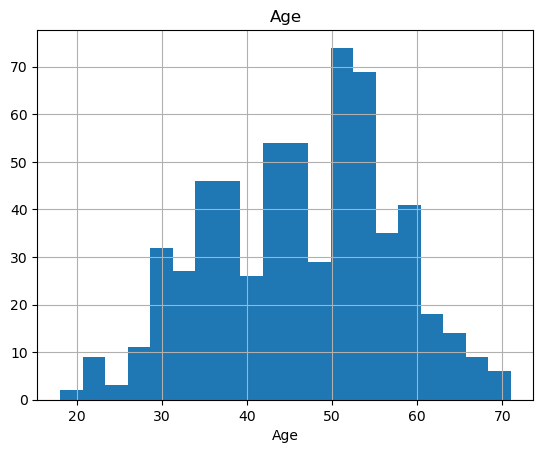

count   605.000
mean    164.790
std       9.920
min     135.000
5%      150.000
10%     151.000
20%     155.000
30%     158.000
40%     162.000
50%     165.000
60%     169.000
70%     171.000
80%     174.000
90%     177.600
95%     180.000
99%     185.000
100%    193.000
max     193.000
Name: Height, dtype: float64


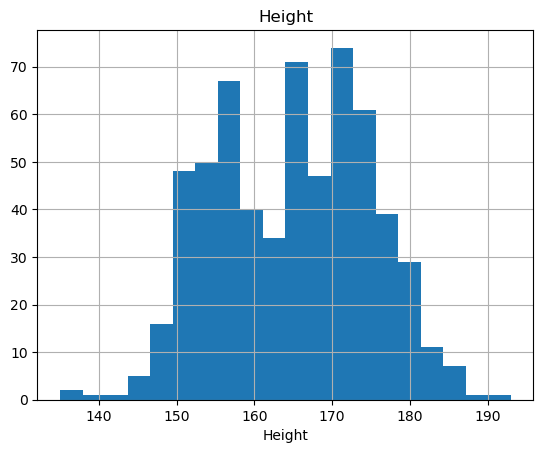

count   605.000
mean     86.403
std      14.379
min      48.000
5%       65.000
10%      69.000
20%      74.800
30%      79.000
40%      83.000
50%      85.000
60%      89.400
70%      92.000
80%      97.000
90%     104.000
95%     111.000
99%     126.000
100%    158.000
max     158.000
Name: Weight, dtype: float64


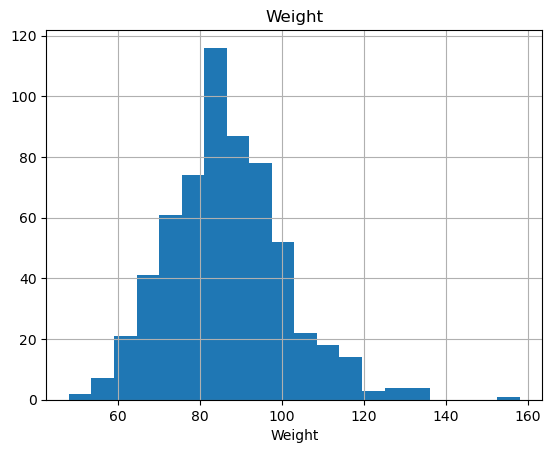

count   605.000
mean     31.869
std       5.107
min      18.290
5%       24.610
10%      25.926
20%      27.874
30%      29.040
40%      30.236
50%      31.210
60%      32.398
70%      33.778
80%      35.494
90%      38.538
95%      40.786
99%      48.209
100%     56.000
max      56.000
Name: Body Mass Index, dtype: float64


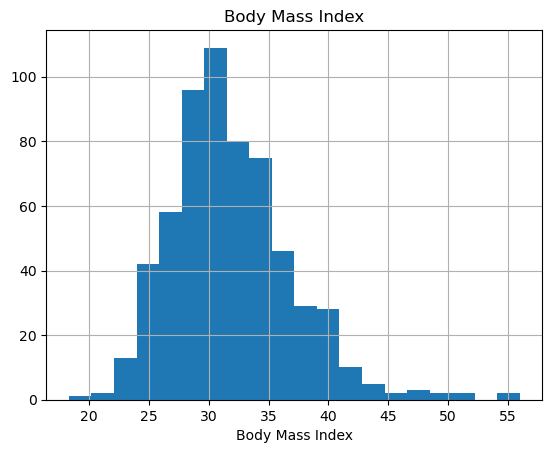

count   576.000
mean    109.441
std      10.589
min      63.000
5%       95.000
10%      98.000
20%     101.000
30%     104.000
40%     106.000
50%     108.000
60%     110.000
70%     114.000
80%     116.000
90%     122.500
95%     127.000
99%     142.500
100%    155.000
max     155.000
Name: Waist Circumference, dtype: float64


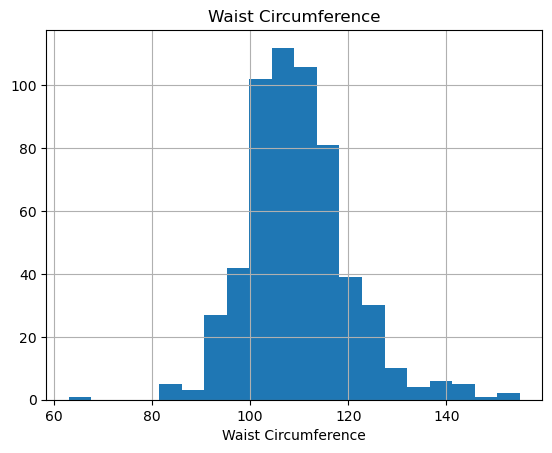

count   598.000
mean    104.306
std      10.386
min      70.000
5%       89.000
10%      91.000
20%      95.000
30%      99.000
40%     102.000
50%     104.000
60%     106.000
70%     109.000
80%     112.000
90%     117.000
95%     122.000
99%     130.030
100%    147.000
max     147.000
Name: Hip Circumference, dtype: float64


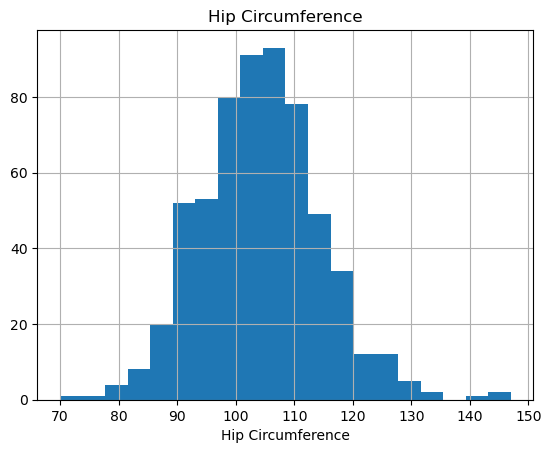

count   605.000
mean    127.276
std      15.315
min      90.000
5%      110.000
10%     110.000
20%     120.000
30%     120.000
40%     120.000
50%     121.000
60%     130.000
70%     130.000
80%     140.000
90%     150.000
95%     160.000
99%     179.880
100%    190.000
max     190.000
Name: Systolic Blood Pressure, dtype: float64


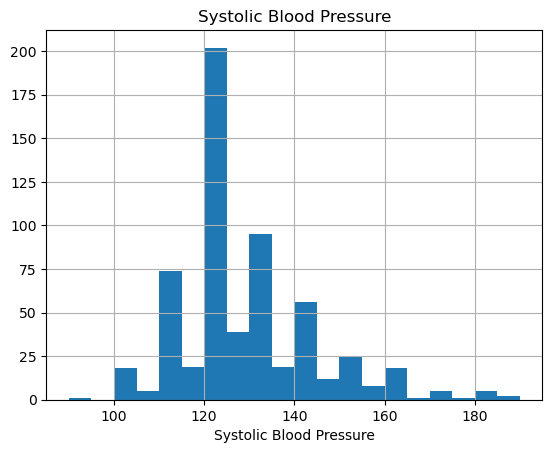

count   605.000
mean     82.423
std       9.942
min      51.000
5%       70.000
10%      70.000
20%      75.000
30%      80.000
40%      80.000
50%      80.000
60%      80.000
70%      86.800
80%      90.000
90%      95.000
95%     100.000
99%     110.000
100%    120.000
max     120.000
Name: Diastolic Blood Pressure, dtype: float64


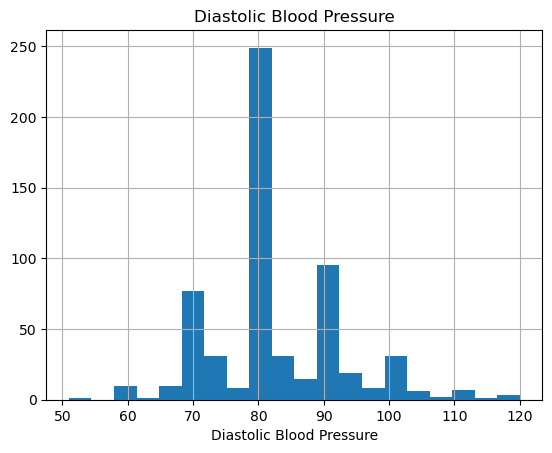

count   605.000
mean     48.724
std      30.248
min      11.000
5%       21.000
10%      24.000
20%      29.000
30%      33.000
40%      37.000
50%      42.000
60%      46.000
70%      53.000
80%      61.200
90%      77.000
95%     103.800
99%     161.760
100%    302.000
max     302.000
Name: AST, dtype: float64


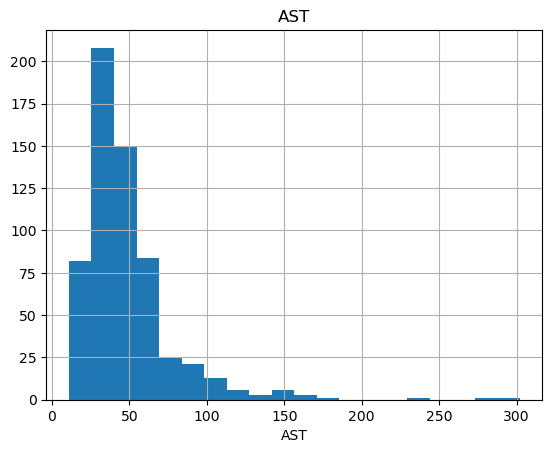

count   605.000
mean     76.524
std      49.417
min      12.000
5%       21.200
10%      28.000
20%      38.000
30%      48.000
40%      57.000
50%      66.000
60%      77.000
70%      89.000
80%     106.000
90%     134.600
95%     174.000
99%     270.880
100%    343.000
max     343.000
Name: ALT, dtype: float64


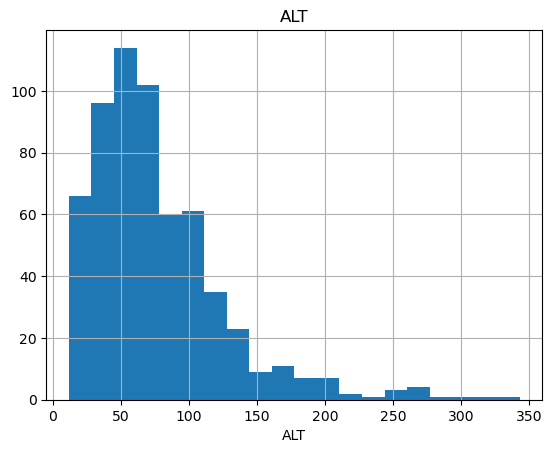

count   604.000
mean    108.752
std      66.752
min      25.000
5%       53.000
10%      59.000
20%      66.000
30%      75.000
40%      80.000
50%      89.500
60%      97.000
70%     109.100
80%     136.000
90%     186.700
95%     240.850
99%     380.940
100%    625.000
max     625.000
Name: ALP, dtype: float64


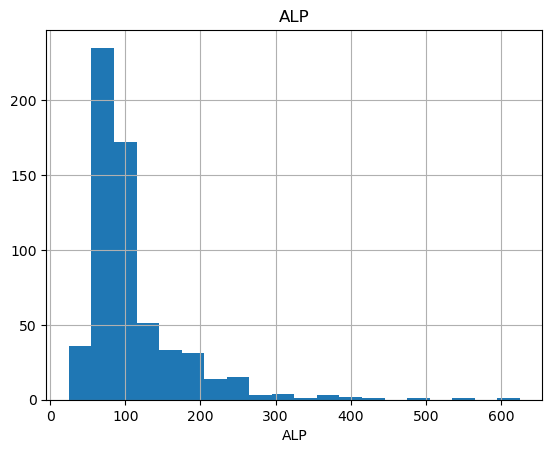

count   602.000
mean     69.121
std      68.698
min       9.000
5%       19.000
10%      24.000
20%      30.000
30%      37.000
40%      43.000
50%      49.000
60%      57.000
70%      69.000
80%      86.000
90%     128.900
95%     179.950
99%     429.120
100%    559.000
max     559.000
Name: GGT, dtype: float64


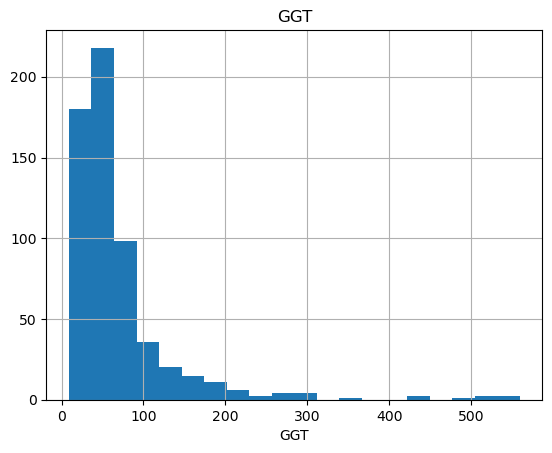

count   561.000
mean    249.232
std      94.306
min      19.000
5%      161.000
10%     169.000
20%     182.000
30%     193.000
40%     203.000
50%     216.000
60%     233.000
70%     266.000
80%     317.000
90%     380.000
95%     421.000
99%     537.600
100%    969.000
max     969.000
Name: LDH, dtype: float64


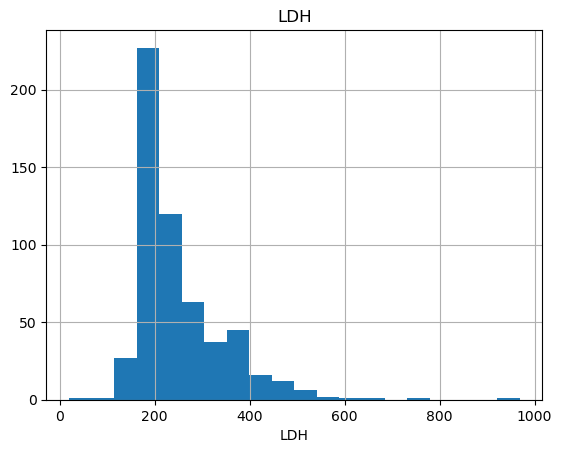

count   604.000
mean      0.797
std       0.601
min       0.050
5%        0.322
10%       0.390
20%       0.480
30%       0.540
40%       0.600
50%       0.655
60%       0.738
70%       0.830
80%       0.970
90%       1.210
95%       1.600
99%       2.878
100%      7.600
max       7.600
Name: Total Bilirubin, dtype: float64


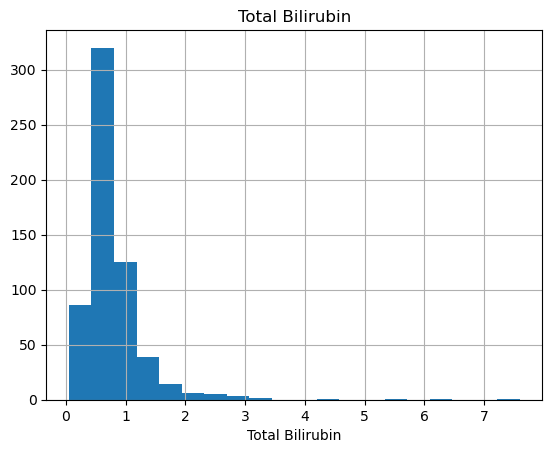

count   604.000
mean      0.210
std       0.168
min       0.010
5%        0.070
10%       0.090
20%       0.110
30%       0.130
40%       0.140
50%       0.170
60%       0.200
70%       0.220
80%       0.260
90%       0.350
95%       0.494
99%       0.899
100%      1.830
max       1.830
Name: Direct Bilirubin, dtype: float64


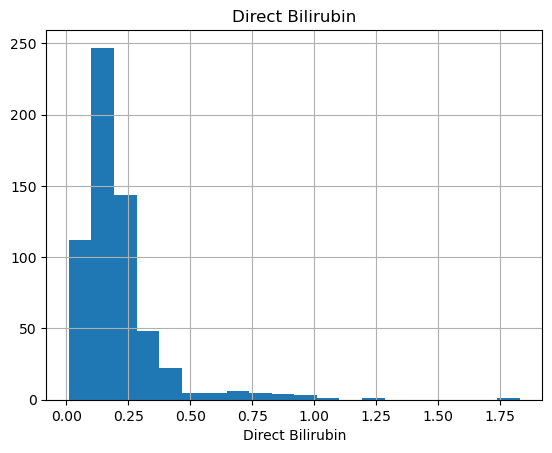

count   523.000
mean      7.782
std       0.459
min       6.400
5%        7.100
10%       7.200
20%       7.400
30%       7.500
40%       7.700
50%       7.800
60%       7.900
70%       8.000
80%       8.200
90%       8.316
95%       8.500
99%       9.000
100%      9.140
max       9.140
Name: Total Protein, dtype: float64


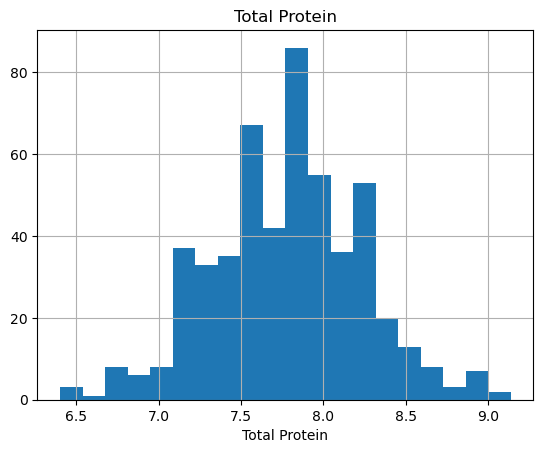

count   605.000
mean      4.670
std       0.379
min       3.400
5%        4.000
10%       4.200
20%       4.400
30%       4.500
40%       4.600
50%       4.700
60%       4.800
70%       4.900
80%       5.000
90%       5.100
95%       5.210
99%       5.500
100%      5.900
max       5.900
Name: Albumin, dtype: float64


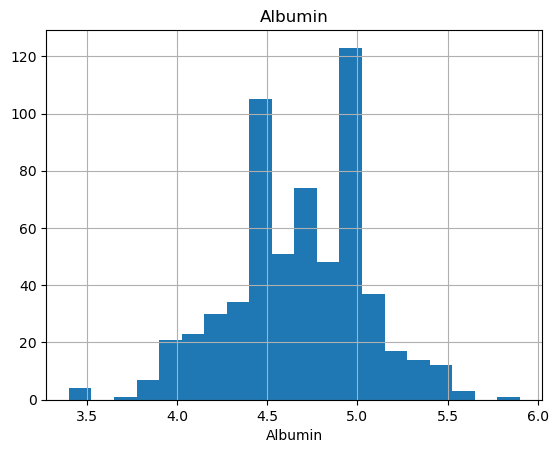

count   605.000
mean    209.702
std      48.395
min      74.000
5%      128.000
10%     150.000
20%     172.800
30%     187.000
40%     200.000
50%     211.000
60%     220.000
70%     232.000
80%     247.000
90%     266.000
95%     284.800
99%     349.440
100%    419.000
max     419.000
Name: Total Cholesterol, dtype: float64


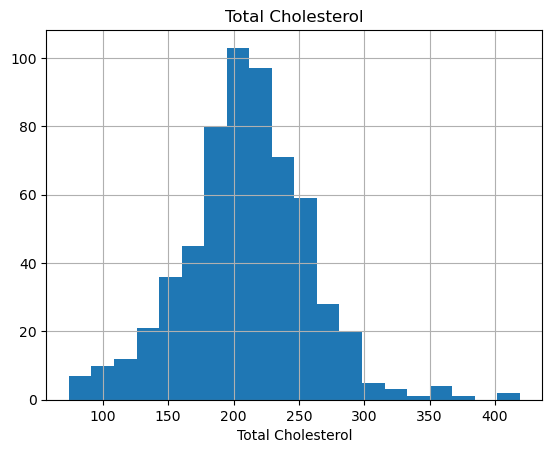

count    604.000
mean     190.848
std      114.890
min       37.000
5%        69.150
10%       85.600
20%      108.000
30%      123.900
40%      148.000
50%      164.500
60%      192.000
70%      217.000
80%      255.200
90%      311.700
95%      397.700
99%      566.580
100%    1107.000
max     1107.000
Name: Triglycerides, dtype: float64


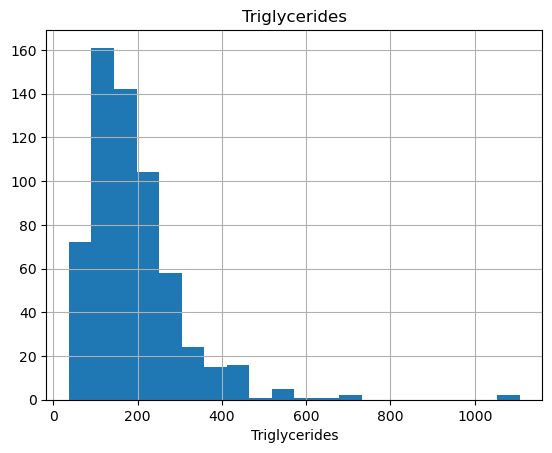

count   604.000
mean     45.390
std      10.544
min      18.000
5%       30.000
10%      34.000
20%      37.000
30%      40.000
40%      42.000
50%      44.000
60%      46.000
70%      49.000
80%      53.000
90%      59.000
95%      64.000
99%      76.940
100%     96.000
max      96.000
Name: HDL, dtype: float64


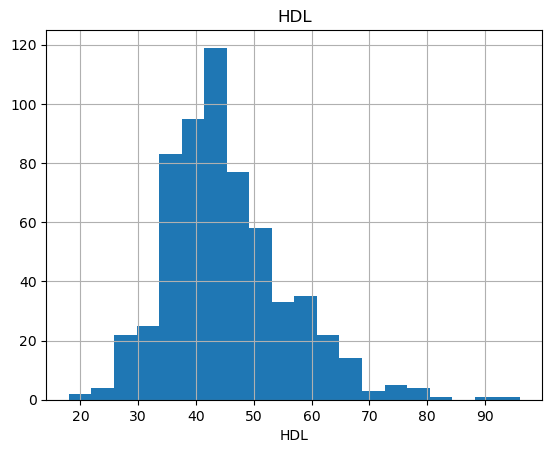

count   602.000
mean    133.947
std      42.797
min      28.000
5%       71.000
10%      83.000
20%     101.200
30%     114.000
40%     124.000
50%     134.000
60%     144.000
70%     153.000
80%     163.000
90%     182.000
95%     193.950
99%     258.740
100%    400.000
max     400.000
Name: LDL, dtype: float64


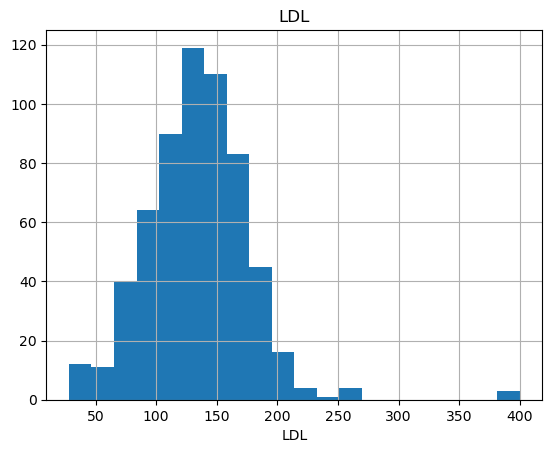

count    183.000
mean      73.398
std      271.573
min        0.000
5%         0.800
10%        1.620
20%        3.394
30%        5.466
40%        8.846
50%       11.540
60%       15.588
70%       22.946
80%       33.624
90%       93.928
95%      371.644
99%      881.700
100%    2925.010
max     2925.010
Name: Microalbumin Spot Urine, dtype: float64


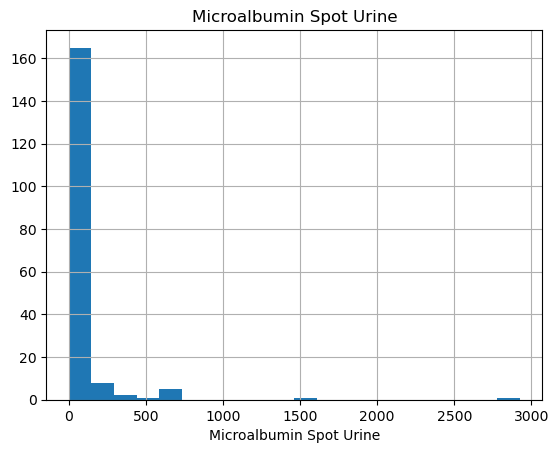

count    115.000
mean      93.039
std      444.777
min        0.750
5%         2.064
10%        2.722
20%        4.554
30%        5.554
40%        6.766
50%        9.460
60%       12.506
70%       17.536
80%       29.610
90%       79.248
95%      326.560
99%     1008.467
100%    4472.000
max     4472.000
Name: Microalbumin/Creatinine Ratio, dtype: float64


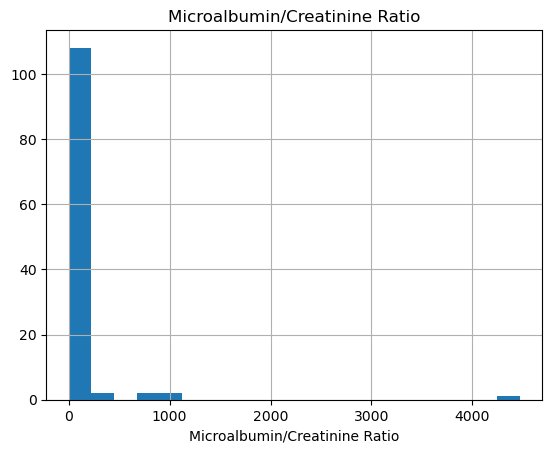

count   293.000
mean      1.878
std       1.344
min       0.020
5%        0.516
10%       0.660
20%       0.954
30%       1.116
40%       1.338
50%       1.540
60%       1.840
70%       2.168
80%       2.630
90%       3.326
95%       4.328
99%       5.775
100%     13.300
max      13.300
Name: TSH, dtype: float64


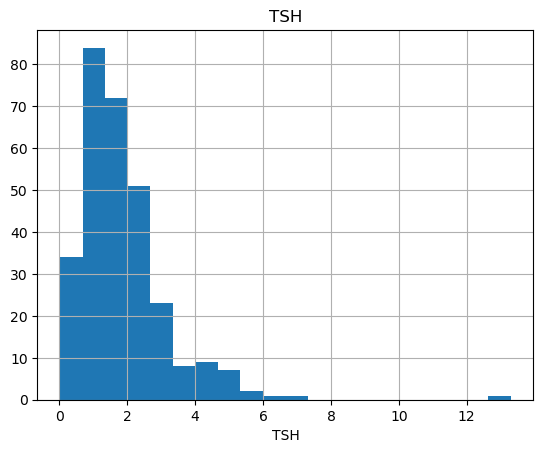

count   153.000
mean    136.316
std      99.792
min       0.720
5%       51.600
10%      59.000
20%      69.400
30%      82.000
40%      96.000
50%     110.000
60%     128.600
70%     150.400
80%     191.000
90%     241.000
95%     267.400
99%     549.680
100%    773.000
max     773.000
Name: CK, dtype: float64


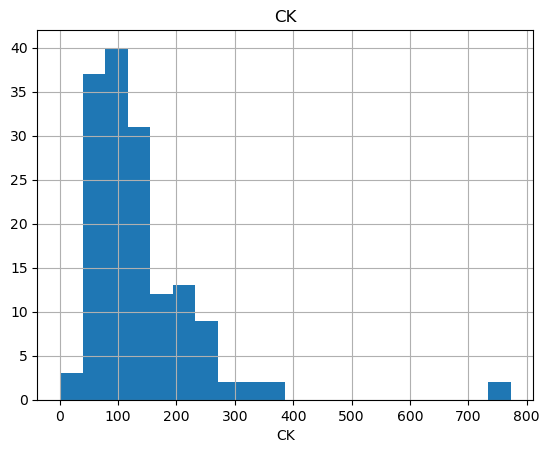

count     604.000
mean     7248.725
std      1899.583
min      2400.000
5%       4700.000
10%      5000.000
20%      5600.000
30%      6100.000
40%      6600.000
50%      7000.000
60%      7500.000
70%      8000.000
80%      8800.000
90%      9800.000
95%     10717.000
99%     12300.000
100%    14900.000
max     14900.000
Name: Leukocyte, dtype: float64


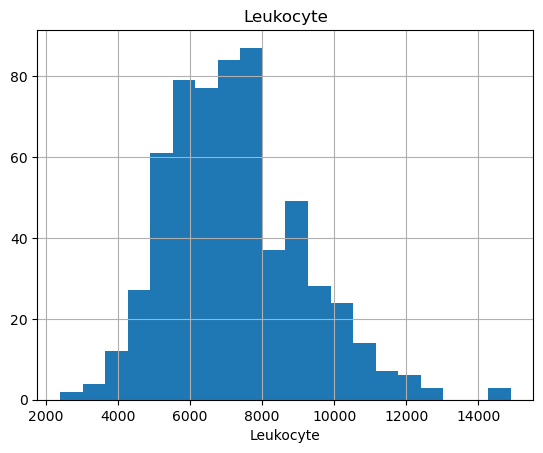

count   604.000
mean     14.319
std       1.712
min       7.100
5%       11.400
10%      12.100
20%      13.000
30%      13.600
40%      14.000
50%      14.400
60%      14.900
70%      15.300
80%      15.700
90%      16.300
95%      16.870
99%      17.597
100%     18.900
max      18.900
Name: Hemoglobin, dtype: float64


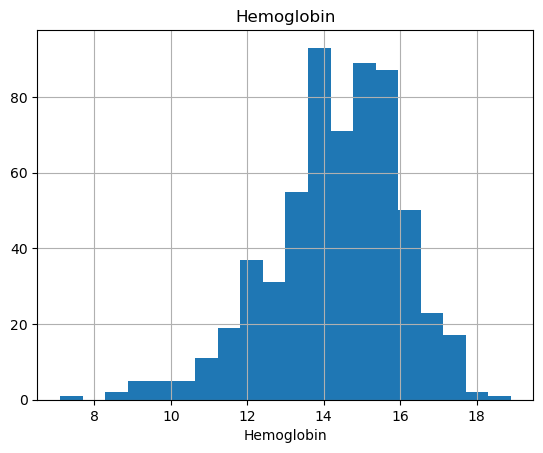

count   604.000
mean    241.925
std      68.000
min      77.000
5%      127.450
10%     159.000
20%     187.600
30%     206.800
40%     224.200
50%     240.000
60%     253.000
70%     270.000
80%     292.000
90%     329.700
95%     364.700
99%     423.910
100%    543.000
max     543.000
Name: Trombosit, dtype: float64


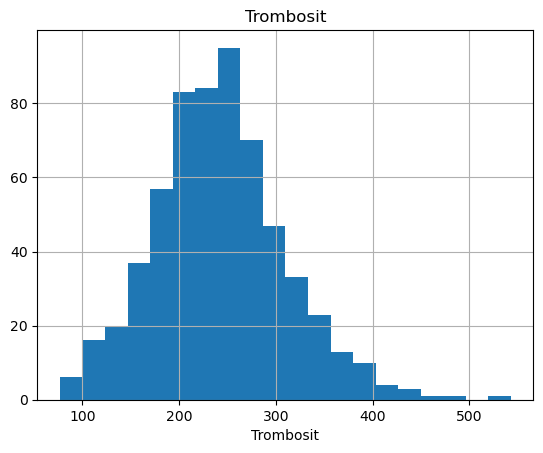

count   603.000
mean     85.489
std       7.244
min      13.100
5%       75.620
10%      79.720
20%      82.400
30%      83.760
40%      85.100
50%      86.000
60%      87.500
70%      88.440
80%      90.000
90%      92.000
95%      94.000
99%      95.988
100%    100.700
max     100.700
Name: Mean Corpuscular Volume, dtype: float64


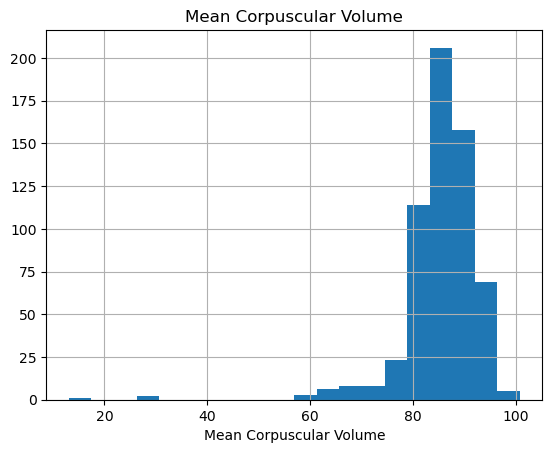

count   591.000
mean      8.790
std       1.291
min       5.620
5%        7.105
10%       7.400
20%       7.800
30%       8.150
40%       8.400
50%       8.600
60%       8.900
70%       9.200
80%       9.600
90%      10.200
95%      10.800
99%      12.560
100%     18.000
max      18.000
Name: Mean Platelet Volume, dtype: float64


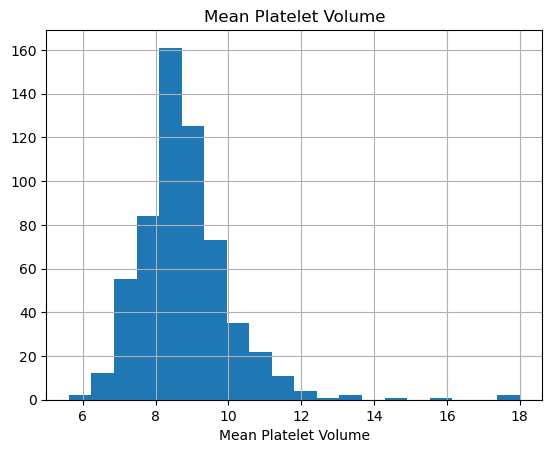

count   237.000
mean     12.982
std       1.089
min       7.500
5%       11.200
10%      11.700
20%      12.300
30%      12.500
40%      12.800
50%      13.000
60%      13.200
70%      13.400
80%      13.700
90%      14.200
95%      14.720
99%      15.864
100%     16.600
max      16.600
Name: PT, dtype: float64


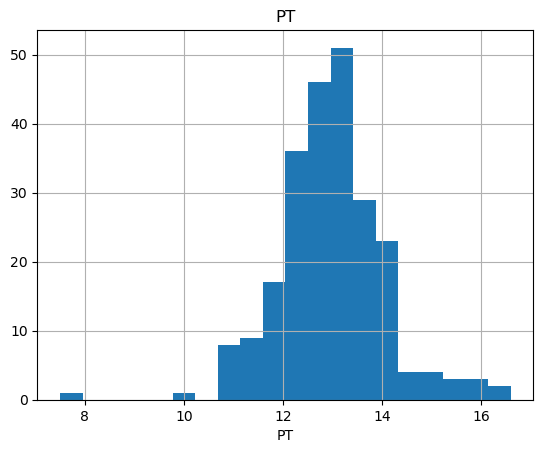

count   304.000
mean      1.041
std       0.157
min       0.190
5%        0.892
10%       0.900
20%       0.940
30%       0.990
40%       1.000
50%       1.020
60%       1.038
70%       1.060
80%       1.100
90%       1.180
95%       1.300
99%       1.700
100%      1.900
max       1.900
Name: INR, dtype: float64


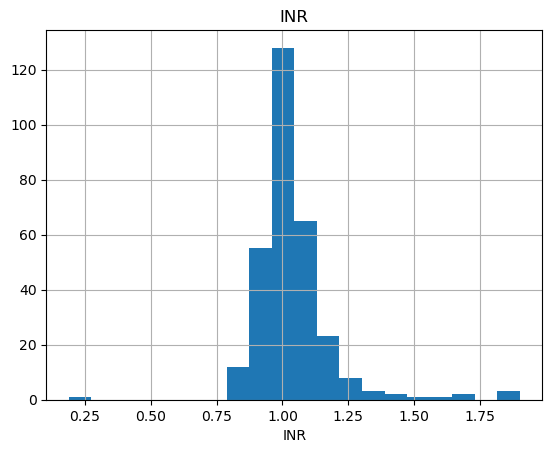

count   193.000
mean     22.683
std      11.361
min       6.180
5%        9.280
10%      11.280
20%      14.138
30%      15.976
40%      17.590
50%      20.450
60%      22.402
70%      25.946
80%      29.862
90%      36.000
95%      44.084
99%      62.167
100%     66.000
max      66.000
Name: Vitamin D, dtype: float64


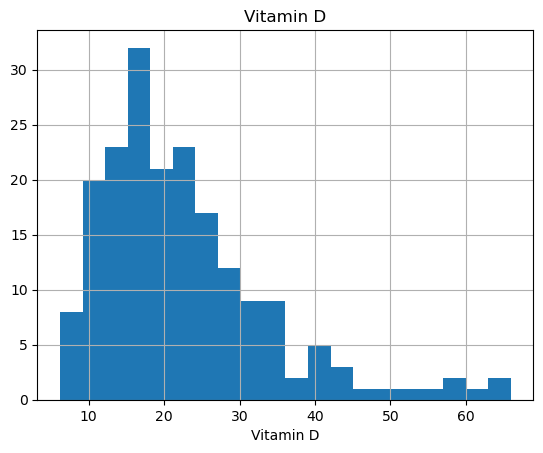

count   588.000
mean    129.078
std     121.495
min       3.800
5%       11.410
10%      20.000
20%      37.000
30%      53.000
40%      73.080
50%      91.100
60%     115.200
70%     151.700
80%     211.000
90%     281.300
95%     368.650
99%     555.839
100%    821.200
max     821.200
Name: Ferritin, dtype: float64


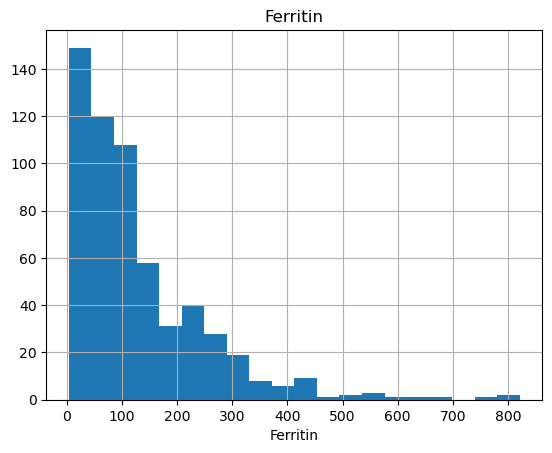

count   288.000
mean      0.285
std       0.075
min       0.110
5%        0.200
10%       0.210
20%       0.230
30%       0.250
40%       0.260
50%       0.280
60%       0.290
70%       0.310
80%       0.326
90%       0.370
95%       0.400
99%       0.513
100%      0.730
max       0.730
Name: Ceruloplasmin, dtype: float64


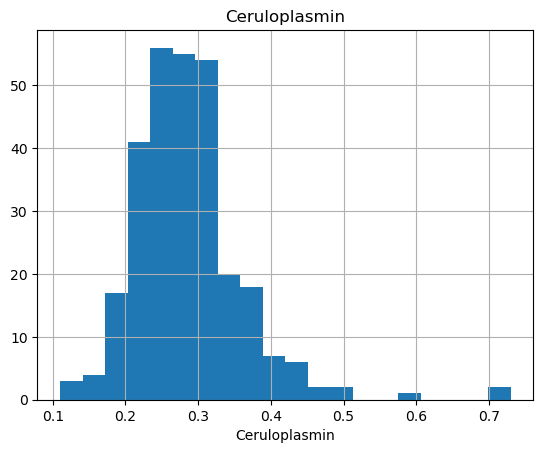

count   167.000
mean      3.776
std       1.550
min       1.080
5%        1.892
10%       2.250
20%       2.684
30%       2.986
40%       3.188
50%       3.430
60%       3.824
70%       4.232
80%       4.604
90%       5.370
95%       6.460
99%       9.494
100%     10.900
max      10.900
Name: C Peptide, dtype: float64


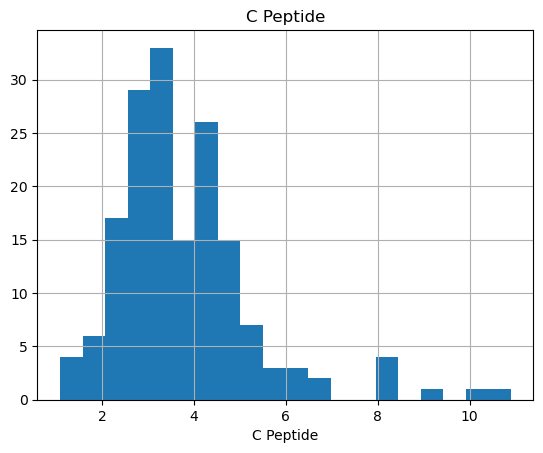

count   601.000
mean    108.845
std      30.863
min      66.000
5%       79.000
10%      84.000
20%      90.000
30%      94.000
40%      97.000
50%     100.000
60%     105.000
70%     112.000
80%     122.000
90%     139.000
95%     170.000
99%     240.000
100%    307.000
max     307.000
Name: Glucose, dtype: float64


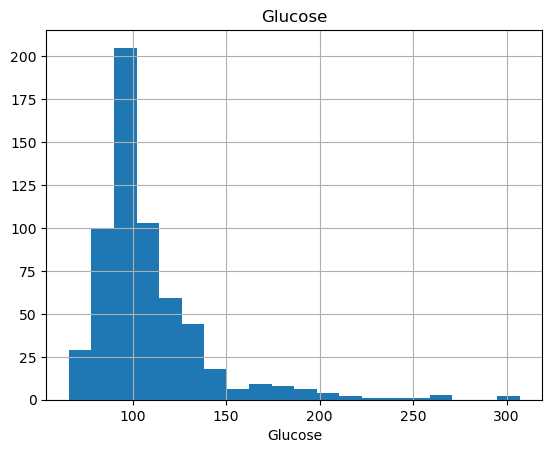

count   277.000
mean     18.692
std      11.475
min       1.850
5%        5.848
10%       8.000
20%      10.830
30%      12.180
40%      13.820
50%      16.000
60%      17.584
70%      20.302
80%      25.748
90%      33.828
95%      44.650
99%      56.423
100%     76.120
max      76.120
Name: Insulin, dtype: float64


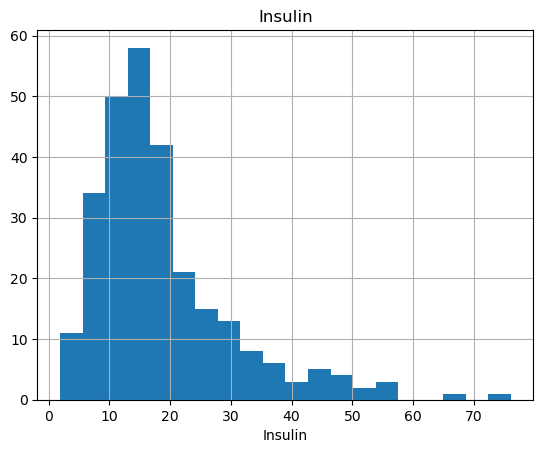

count   277.000
mean      5.285
std       4.064
min       0.320
5%        1.402
10%       1.844
20%       2.452
30%       3.108
40%       3.464
50%       4.020
60%       4.596
70%       5.528
80%       7.456
90%      11.060
95%      13.286
99%      18.866
100%     28.760
max      28.760
Name: HOMA, dtype: float64


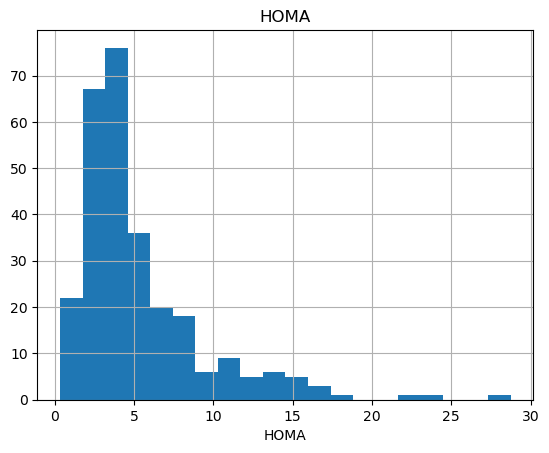

count   254.000
mean      6.179
std       1.464
min       0.700
5%        3.880
10%       4.318
20%       5.100
30%       5.379
40%       5.776
50%       6.200
60%       6.594
70%       7.030
80%       7.400
90%       7.988
95%       8.460
99%       9.063
100%     11.070
max      11.070
Name: Uric Acid, dtype: float64


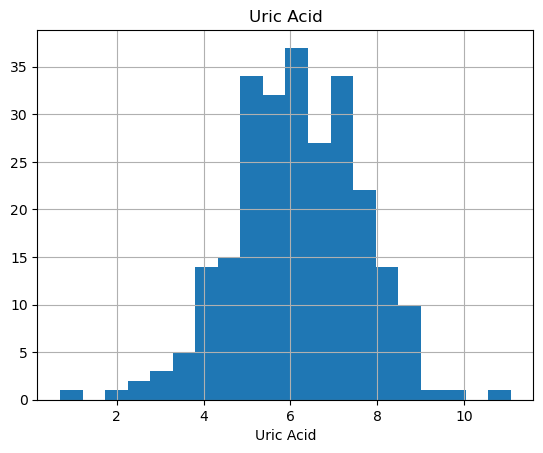

count   305.000
mean     17.998
std       7.706
min       6.000
5%        9.058
10%      10.400
20%      12.000
30%      13.000
40%      14.000
50%      16.000
60%      17.000
70%      20.000
80%      23.200
90%      29.600
95%      34.600
99%      41.000
100%     51.000
max      51.000
Name: BUN, dtype: float64


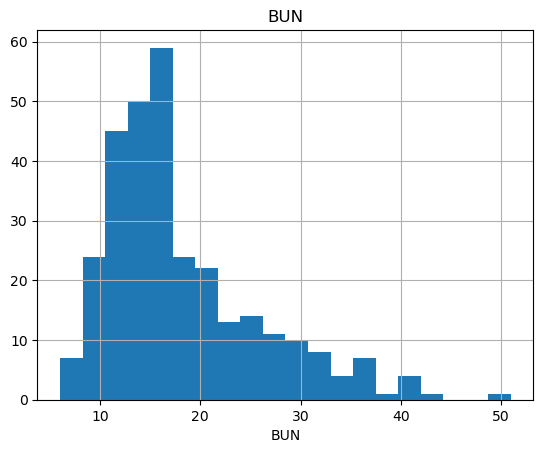

count   305.000
mean      0.821
std       0.199
min       0.410
5%        0.522
10%       0.570
20%       0.640
30%       0.702
40%       0.770
50%       0.820
60%       0.864
70%       0.920
80%       0.992
90%       1.080
95%       1.120
99%       1.200
100%      2.130
max       2.130
Name: Creatinine, dtype: float64


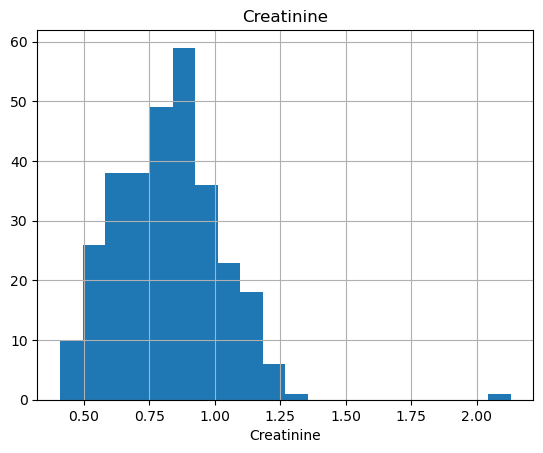

count   564.000
mean      6.016
std       1.009
min       3.520
5%        4.873
10%       5.043
20%       5.334
30%       5.500
40%       5.600
50%       5.800
60%       6.000
70%       6.200
80%       6.600
90%       7.300
95%       7.900
99%       9.937
100%     11.100
max      11.100
Name: Hemoglobin - A1C, dtype: float64


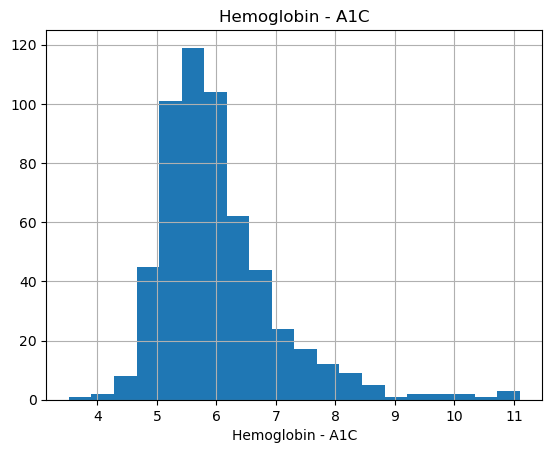

In [8]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

In [9]:
# Adım 4: Hedef değişken analizi yaptım

def target_analysis_num(dataframe, target, num_col):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n\n")
    
for col in num_cols:
    target_analysis_num(df, "Type of Disease (Mild illness=1, Severe illness=2)", col)

                                                      Age
Type of Disease (Mild illness=1, Severe illness=2)       
1                                                  46.542
2                                                  46.277



                                                    Height
Type of Disease (Mild illness=1, Severe illness=2)        
1                                                  165.407
2                                                  164.723



                                                    Weight
Type of Disease (Mild illness=1, Severe illness=2)        
1                                                   82.932
2                                                   86.778



                                                    Body Mass Index
Type of Disease (Mild illness=1, Severe illness=2)                 
1                                                            30.291
2                                                            32.039



            

In [10]:
# Korelasyon matrisi
df.corr()

,Patient No.,Age,"Gender (Female=1, Male=2)",Height,Weight,Body Mass Index,Waist Circumference,Hip Circumference,Systolic Blood Pressure,Diastolic Blood Pressure,"Diyabetes Mellitus (No=0, Yes=1)","Hypertension (No=0, Yes=1)","Hyperlipidemia (No=0, Yes=1)","Metabolic syndrome (No=0, Yes=1)","Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)",AST,ALT,ALP,GGT,LDH,Total Bilirubin,Direct Bilirubin,Total Protein,Albumin,Total Cholesterol,Triglycerides,HDL,LDL,Microalbumin Spot Urine,Microalbumin/Creatinine Ratio,TSH,CK,Leukocyte,Hemoglobin,Trombosit,Mean Corpuscular Volume,Mean Platelet Volume,PT,INR,Vitamin D,Ferritin,Ceruloplasmin,C Peptide,Glucose,Insulin,HOMA,"Insulin resistance according to HOMA (insulin resistance = 1, no insulin resistance = 2)",Uric Acid,BUN,Creatinine,Hemoglobin - A1C,Steatosis,Activity,Fibrosis,NAS score according to Kleiner,"NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)","Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)","Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)","Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)","Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)","Diagnosis according to SAF (NASH=1, NAFL=2)","Type of Disease (Mild illness=1, Severe illness=2)"
Patient No.,1.000,0.090,-0.053,-0.079,-0.032,0.033,0.003,-0.065,-0.033,-0.018,-0.019,0.064,-0.043,0.009,0.005,0.017,-0.023,0.062,0.046,-0.095,-0.179,-0.164,0.043,-0.074,0.053,0.029,0.074,0.034,0.006,0.069,-0.052,-0.176,-0.063,-0.027,-0.023,0.011,0.036,0.128,0.060,-0.055,-0.100,0.052,-0.044,-0.002,-0.154,-0.092,0.164,-0.073,0.117,0.033,0.062,-0.423,0.027,-0.006,-0.146,-0.783,-0.051,-0.026,0.040,0.074,0.134,-0.193
Age,0.090,1.000,-0.295,-0.327,-0.118,0.121,0.100,0.114,0.203,0.071,0.287,0.397,0.176,0.178,-0.060,-0.130,-0.332,0.099,0.037,-0.080,-0.079,-0.103,-0.108,-0.297,0.072,-0.061,0.230,0.036,0.034,0.111,-0.070,-0.246,-0.097,-0.182,-0.145,0.090,0.082,0.159,0.119,0.192,-0.050,0.116,0.038,0.257,0.026,0.141,-0.166,-0.095,-0.044,-0.171,0.229,-0.106,0.080,0.255,0.022,-0.046,0.132,0.237,0.230,0.171,-0.033,-0.007
"Gender (Female=1, Male=2)",-0.053,-0.295,1.000,0.749,0.275,-0.283,-0.329,-0.007,-0.152,-0.059,-0.188,-0.260,-0.022,-0.236,0.202,-0.088,0.126,-0.113,0.007,-0.108,0.171,0.113,-0.053,0.229,-0.055,0.132,-0.269,-0.027,0.012,0.077,-0.171,0.375,0.049,0.593,-0.199,0.069,-0.026,0.000,-0.117,0.030,0.321,-0.194,0.058,-0.142,0.010,-0.067,0.116,0.316,0.113,0.503,-0.186,0.034,-0.089,-0.154,-0.061,0.006,-0.170,-0.084,-0.115,-0.080,0.073,-0.064
Height,-0.079,-0.327,0.749,1.000,0.440,-0.297,-0.195,0.054,-0.095,-0.014,-0.194,-0.205,-0.050,-0.173,0.185,-0.033,0.196,-0.088,-0.003,-0.067,0.147,0.099,-0.048,0.249,-0.029,0.088,-0.225,0.040,0.036,0.109,-0.183,0.296,-0.006,0.471,-0.170,0.032,0.040,0.026,-0.106,0.068,0.268,-0.139,0.055,-0.150,0.047,-0.057,0.032,0.286,0.044,0.475,-0.221,0.056,-0.046,-0.139,-0.023,0.043,-0.128,-0.096,-0.125,-0.038,0.028,-0.020
Weight,-0.032,-0.118,0.275,0.440,1.000,0.720,0.597,0.759,0.162,0.180,0.044,0.059,-0.029,0.165,0.037,0.008,0.053,-0.054,-0.075,0.035,0.039,-0.011,-0.134,-0.075,-0.037,0.047,-0.082,0.014,0.046,0.017,-0.012,0.357,-0.001,0.120,-0.164,-0.065,0.069,0.094,0.082,-0.109,0.064,-0.022,0.092,-0.032,0.205,0.068,-0.176,0.200,-0.066,0.125,0.002,0.021,0.073,0.108,0.054,0.047,0.080,0.083,0.075,0.101,-0.069,0.079
Body Mass Index,0.033,0.121,-0.283,-0.297,0.720,1.000,0.801,0.761,0.248,0.206,0.194,0.218,0.002,0.293,-0.097,0.025,-0.104,0.022,-0.084,0.095,-0.079,-0.089,-0.106,-0.268,-0.021,-0.030,0.089,-0.020,0.025,-0.065,0.139,0.159,0.004,-0.235,-0.049,-0.094,0.044,0.081,0.194,-0.187,-0.143,0.108,0.029,0.074,0.158,0.085,-0.220,-0.028,-0.103,-0.261,0.168,-0.033,0.116,0.205,0.070,0.007,0.166,0.152,0.166,0.127,-0.096,0.102
Waist Circumference,0.003,0.100,-0.329,-0.195,0.597,0.801,1.000,0.698,0.175,0.125,0.150,0.208,-0.097,0.238,-0.089,0.055,-0.078,0.001,-0.075,0.048,-0.093,

In [11]:
#Eksik değerlerin sayısı ve oranı

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")
    if na_name:
        return na_columns
    
na_columns = missing_values_table(df, True)

                                                    n_miss  ratio
Microalbumin/Creatinine Ratio                          490 80.990
CK                                                     452 74.710
C Peptide                                              438 72.400
Microalbumin Spot Urine                                422 69.750
Vitamin D                                              412 68.100
PT                                                     368 60.830
Uric Acid                                              351 58.020
Insulin                                                328 54.210
Insulin resistance according to HOMA (insulin r...     328 54.210
HOMA                                                   328 54.210
Ceruloplasmin                                          317 52.400
TSH                                                    312 51.570
INR                                                    301 49.750
BUN                                                    300 49.590
Creatinine

In [12]:
drop_null_cols = [col for col in df.columns if df[col].isnull().sum() >= 300]
df.drop(columns = drop_null_cols, inplace=True)

In [13]:
df.drop(columns = "Patient No.",inplace=True)

In [14]:
na_columns = missing_values_table(df, True)

                                                    n_miss  ratio
Total Protein                                           82 13.550
LDH                                                     44  7.270
Hemoglobin - A1C                                        41  6.780
Waist Circumference                                     29  4.790
Smoking Status (Never Smoked=1, Left Smoking=2,...      28  4.630
Ferritin                                                17  2.810
Mean Platelet Volume                                    14  2.310
Hip Circumference                                        7  1.160
Glucose                                                  4  0.660
GGT                                                      3  0.500
LDL                                                      3  0.500
Mean Corpuscular Volume                                  2  0.330
ALP                                                      1  0.170
Total Bilirubin                                          1  0.170
Direct Bil

In [15]:
#eksik değerlerin doldurdum

for col in na_columns:
    df.loc[df[col].isnull(), col] = df[col].mode().iloc[0] 

df.isnull().sum()

Age                                                                                            0
Gender (Female=1, Male=2)                                                                      0
Height                                                                                         0
Weight                                                                                         0
Body Mass Index                                                                                0
Waist Circumference                                                                            0
Hip Circumference                                                                              0
Systolic Blood Pressure                                                                        0
Diastolic Blood Pressure                                                                       0
Diyabetes Mellitus (No=0, Yes=1)                                                               0
Hypertension (No=0, Yes=1)    

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

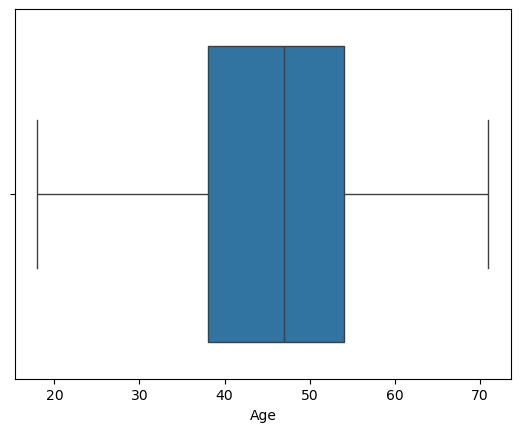

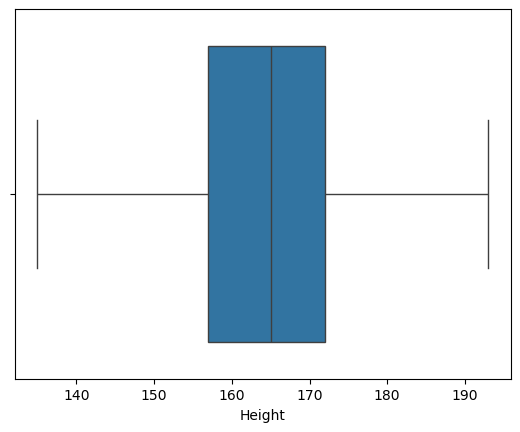

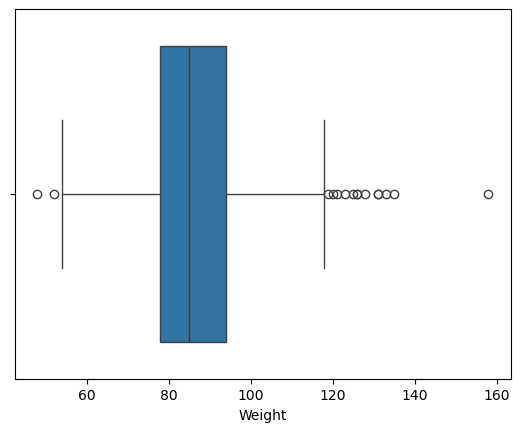

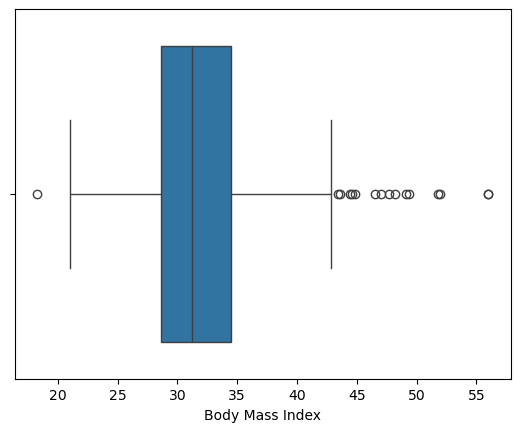

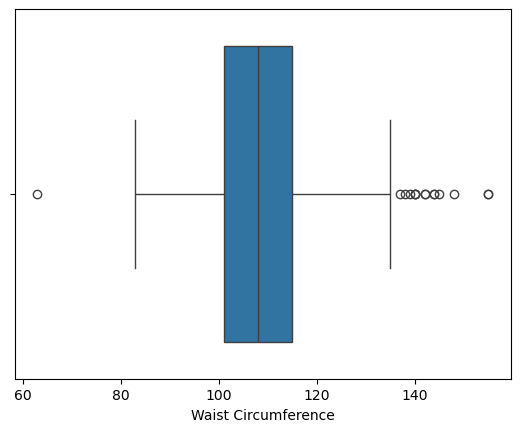

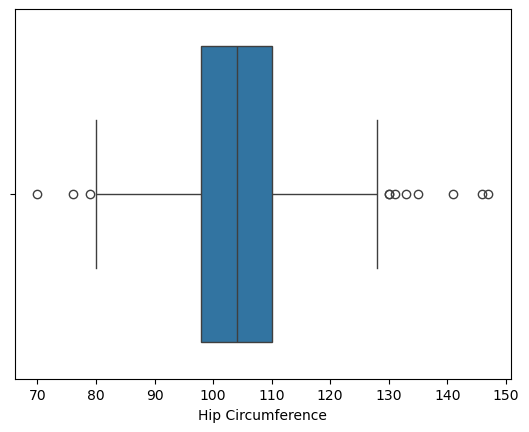

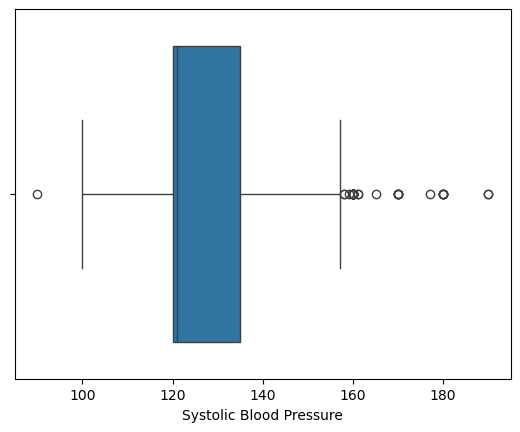

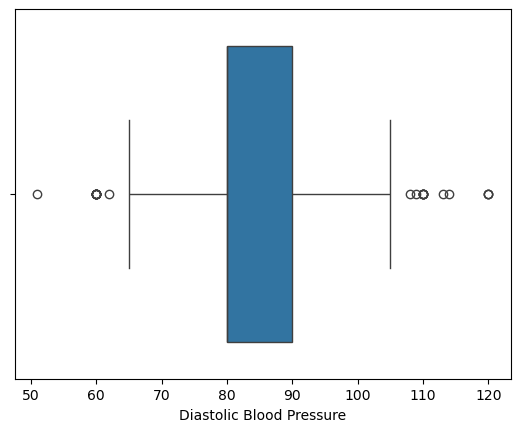

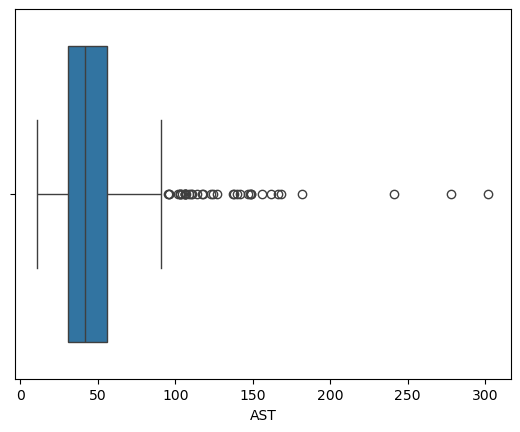

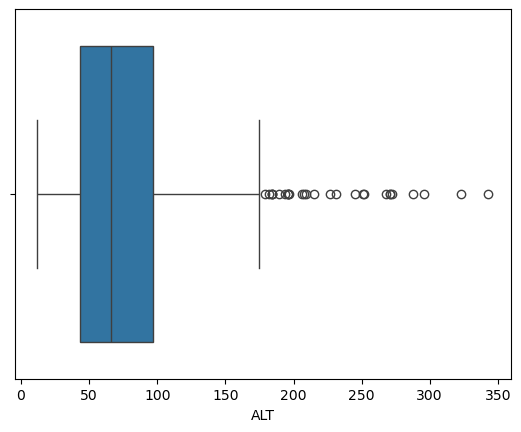

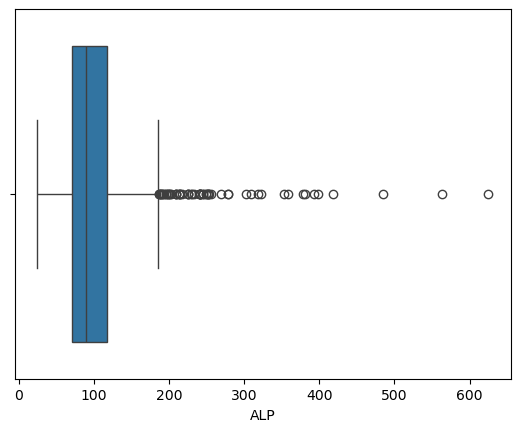

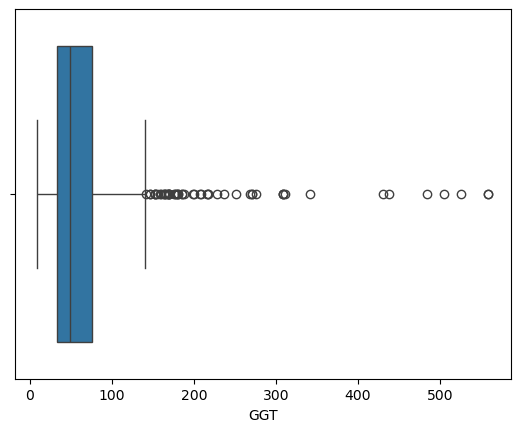

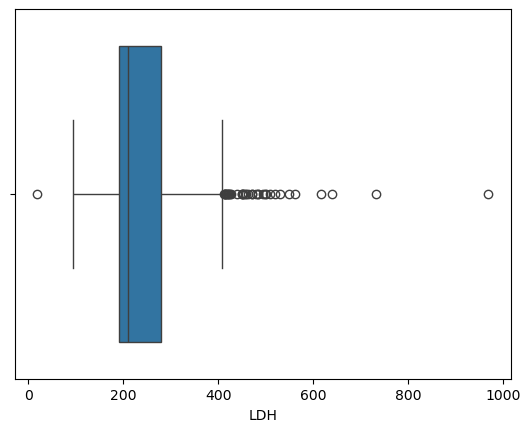

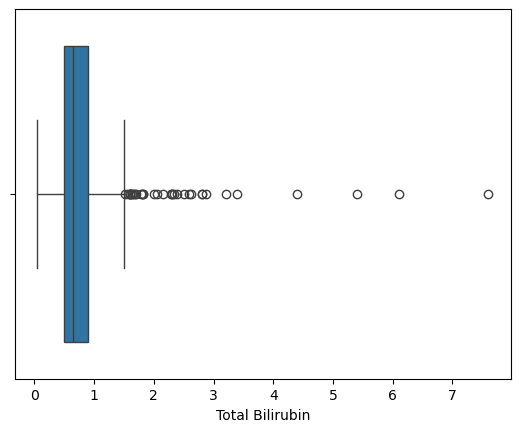

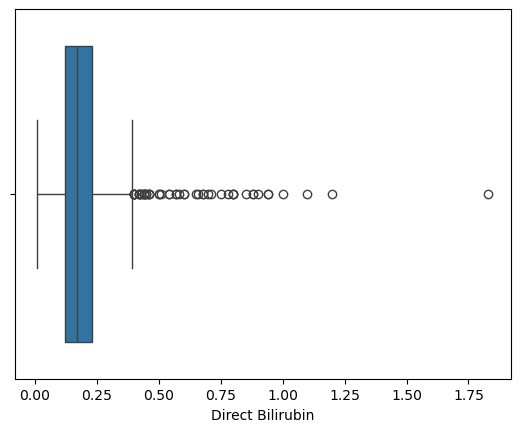

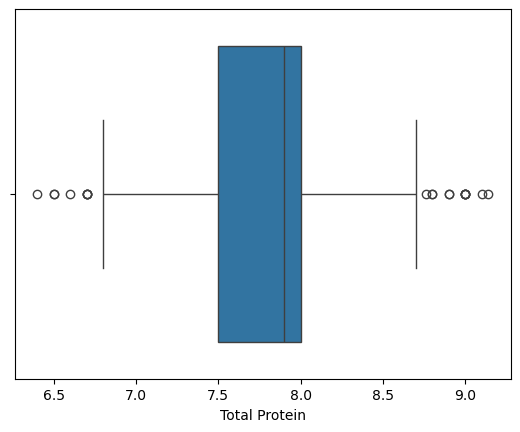

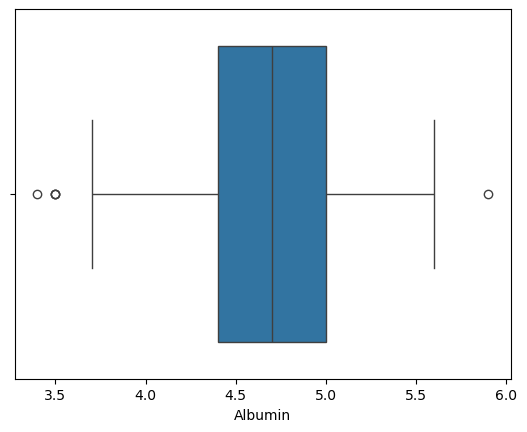

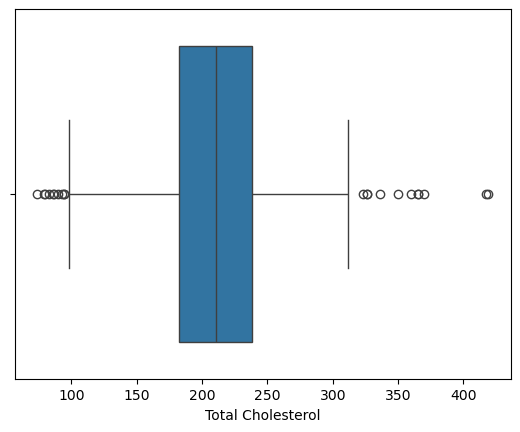

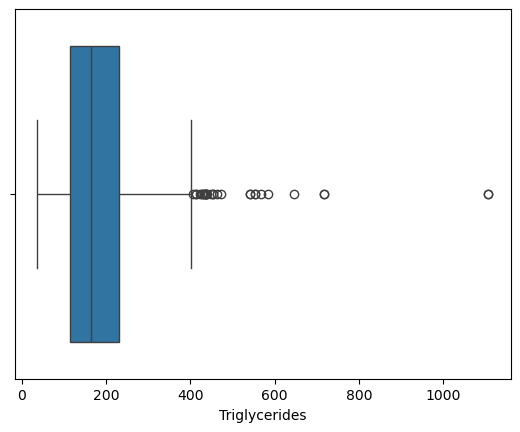

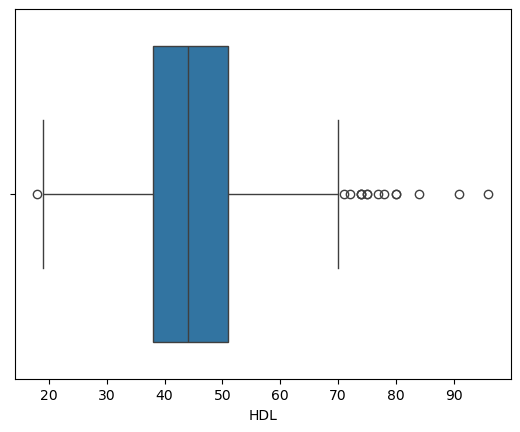

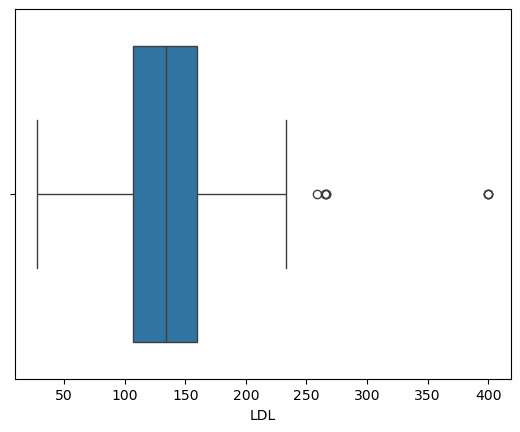

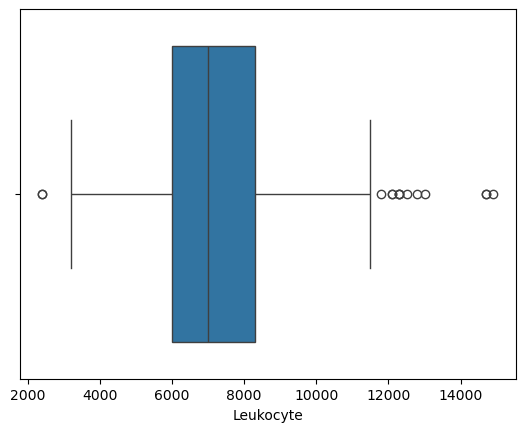

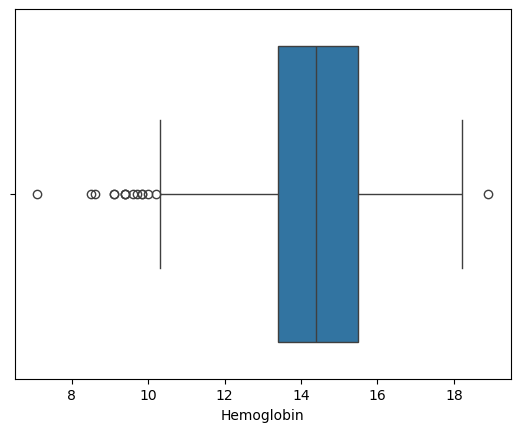

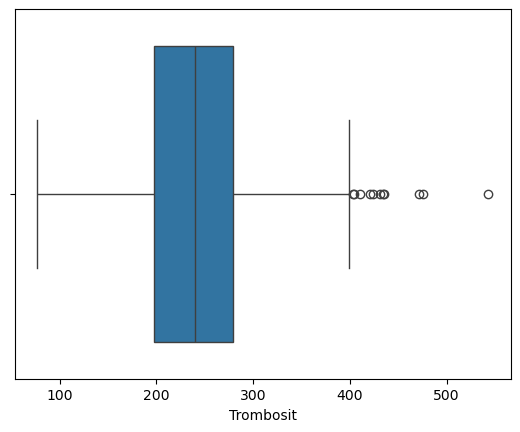

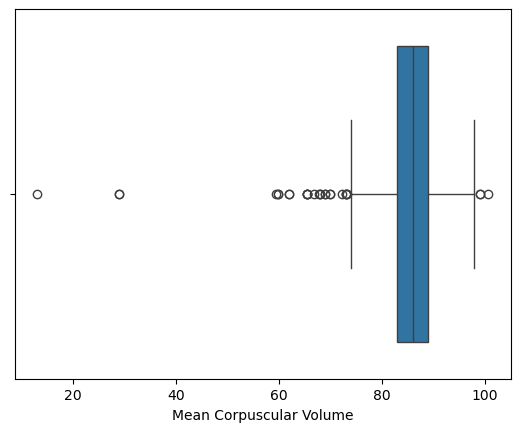

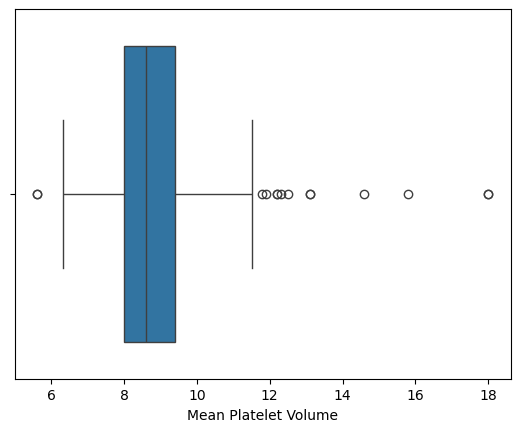

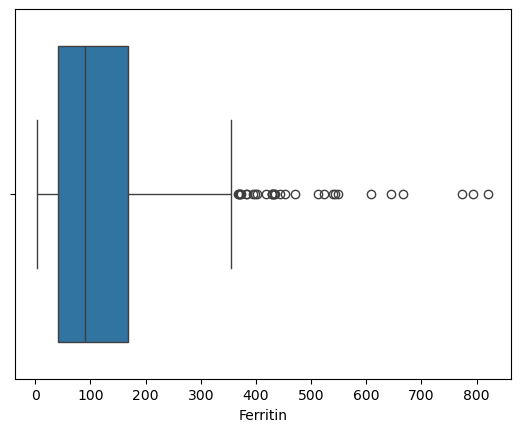

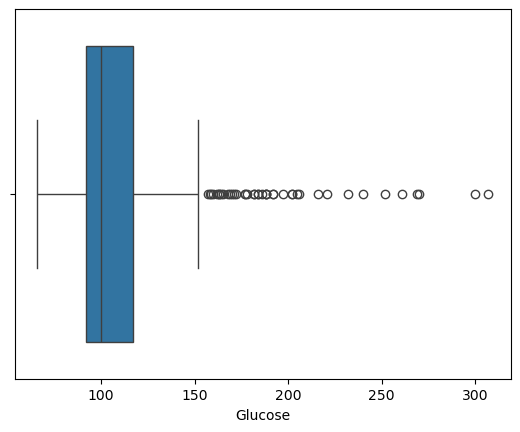

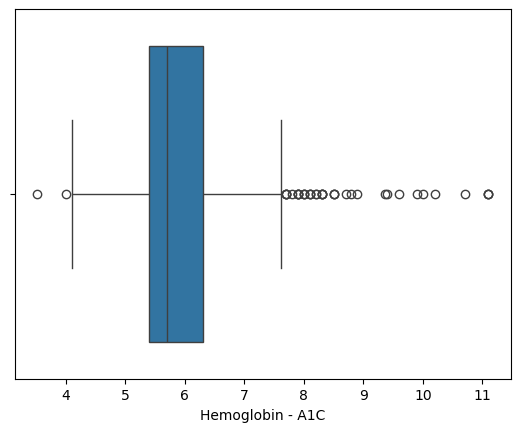

In [17]:
#Aykırı değer analizi yaptım

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

In [18]:

def outlier_threshold(dataframe, col_name, q1=0.1, q3=0.9):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile
    up_limit = quartile3 + 1.5 * interquantile
    
    return low_limit, up_limit

In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Height False
Weight True
Body Mass Index False
Waist Circumference False
Hip Circumference False
Systolic Blood Pressure False
Diastolic Blood Pressure False
AST True
ALT True
ALP True
GGT True
LDH True
Total Bilirubin True
Direct Bilirubin True
Total Protein False
Albumin False
Total Cholesterol False
Triglycerides True
HDL False
LDL True
Leukocyte False
Hemoglobin False
Trombosit False
Mean Corpuscular Volume True
Mean Platelet Volume True
Ferritin True
Glucose True
Hemoglobin - A1C True


In [20]:
#Aykırı değerleri sınır değerleri ile doldurdum.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

C:\Users\kerem\AppData\Local\Temp\ipykernel_11516\2559782422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\kerem\AppData\Local\Temp\ipykernel_11516\2559782422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.09999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\kerem\AppData\Local\Temp\ipykernel_11516\2559782422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.5' has dtype incompatible with int64, please explicitly cast to

In [21]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Height False
Weight False
Body Mass Index False
Waist Circumference False
Hip Circumference False
Systolic Blood Pressure False
Diastolic Blood Pressure False
AST False
ALT False
ALP False
GGT False
LDH False
Total Bilirubin False
Direct Bilirubin False
Total Protein False
Albumin False
Total Cholesterol False
Triglycerides False
HDL False
LDL False
Leukocyte False
Hemoglobin False
Trombosit False
Mean Corpuscular Volume False
Mean Platelet Volume False
Ferritin False
Glucose False
Hemoglobin - A1C False


In [22]:
# Veri setini normalize ettim
cols = [col for col in df.columns if col not in ["Patient No.", "Type of Disease (Mild illness=1, Severe illness=2)"]]
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])

In [23]:
def split(df):
    y = df["Type of Disease (Mild illness=1, Severe illness=2)"]
    X = df.drop(["Type of Disease (Mild illness=1, Severe illness=2)"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = split(df)

In [25]:
def plot_feature_importance(model, X_train, model_name):
    
    importance = model.feature_importances_
    features = X_train.columns
    
    indices = importance.argsort()[-20:]
    plt.rcParams.update({'font.size': 5})

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Özellik Önemi")
    plt.title(model_name)
    plt.show()

MODEL

In [27]:
# Algoritmalar
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (SVM)": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting (XGBoost)": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

# Sonuçları saklamak için boş bir sözlük
results = {}

y_train = y_train.replace({1: 0, 2: 1})
y_test = y_test.replace({1: 0, 2: 1})

# Her model için eğitim ve değerlendirme
for model_name, model in models.items():
    print(f"Model: {model_name}")
    # Model eğitimi
    model.fit(X_train, y_train)
    
    # Tahminler
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Performans metrikleri
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"
    
    # Sonuçları saklama
    results[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    }

# Sonuçları DataFrame olarak göster
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by="F1 Score", ascending=False))

Model: K-Nearest Neighbors (KNN)
Model: Naive Bayes
Model: Decision Tree
Model: Support Vector Machine (SVM)
Model: Random Forest
Model: Gradient Boosting (XGBoost)
                              Accuracy  Precision  Recall  F1 Score  ROC-AUC
Decision Tree                    1.000      1.000   1.000     1.000    1.000
Random Forest                    1.000      1.000   1.000     1.000    1.000
Gradient Boosting (XGBoost)      1.000      1.000   1.000     1.000    1.000
Support Vector Machine (SVM)     0.989      1.000   0.988     0.994    0.998
K-Nearest Neighbors (KNN)        0.984      0.994   0.988     0.991    0.998
Naive Bayes                      0.978      1.000   0.976     0.988    1.000


C:\Users\kerem\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [28]:
# Cross-validation sonuçlarını saklamak için boş bir sözlük
def cross_validate_models(models, X, y, cv=5):
    cv_results = {}
    for model_name, model in models.items():
        print(f"Cross-validating model: {model_name}")
        
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        cv_results[model_name] = {
            "Mean F1 Score": scores.mean(),
            "F1 Score Std Dev": scores.std()
        }

    return pd.DataFrame(cv_results).T

# Cross-validation sonuçlarını hesapla
cv_results_df = cross_validate_models(models, X_train, y_train, cv=5)

# Sonuçları yazdır
print(cv_results_df.sort_values(by="Mean F1 Score", ascending=False))


Cross-validating model: K-Nearest Neighbors (KNN)
Cross-validating model: Naive Bayes
Cross-validating model: Decision Tree
Cross-validating model: Support Vector Machine (SVM)
Cross-validating model: Random Forest
Cross-validating model: Gradient Boosting (XGBoost)


C:\Users\kerem\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kerem\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kerem\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kerem\anaconda3\Lib\site-packages\

                              Mean F1 Score  F1 Score Std Dev
Naive Bayes                           1.000             0.000
Decision Tree                         1.000             0.000
Random Forest                         0.997             0.005
Gradient Boosting (XGBoost)           0.997             0.005
Support Vector Machine (SVM)          0.995             0.005
K-Nearest Neighbors (KNN)             0.987             0.006


Random Forest Sonuçları:

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000

Random Forest Özellik Önemi:



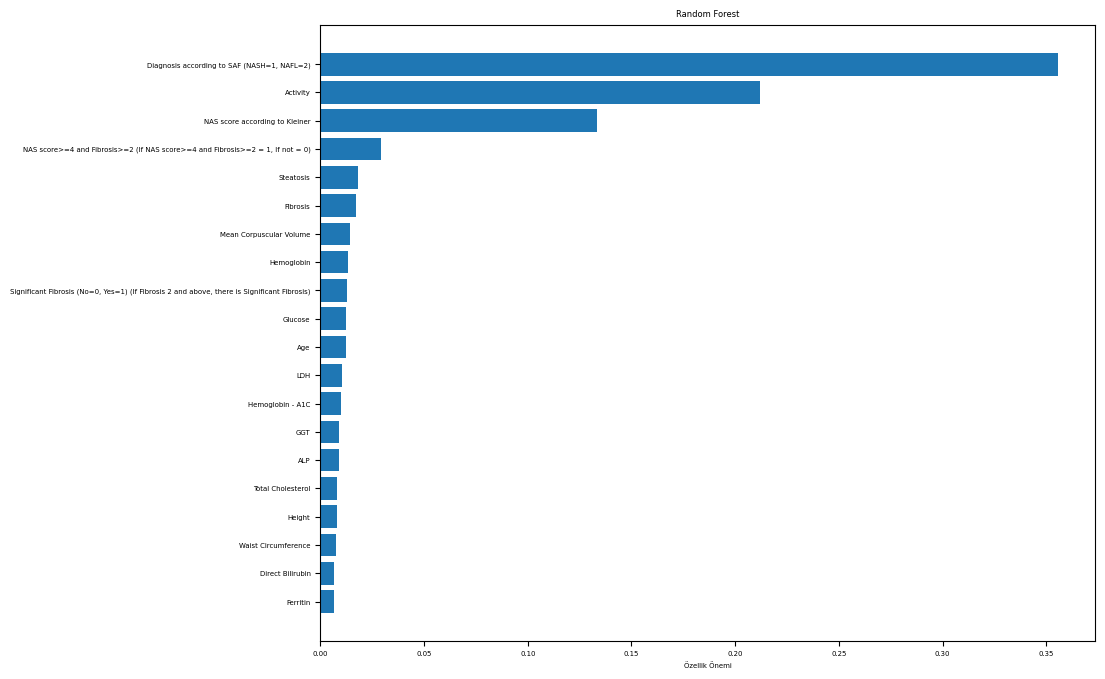

In [29]:
# Random Forest modeliyle eğitim ve değerlendirme
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Tahminler
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Performans metrikleri
rf_acc = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

print("Random Forest Sonuçları:\n")
print(f"Accuracy: {rf_acc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}\n")

# Özellik önemleri
print("Random Forest Özellik Önemi:\n")
plot_feature_importance(rf_model, pd.DataFrame(X_train, columns=X_train.columns), "Random Forest")

C:\Users\kerem\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Sonuçları:

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000

XGBoost Özellik Önemi:



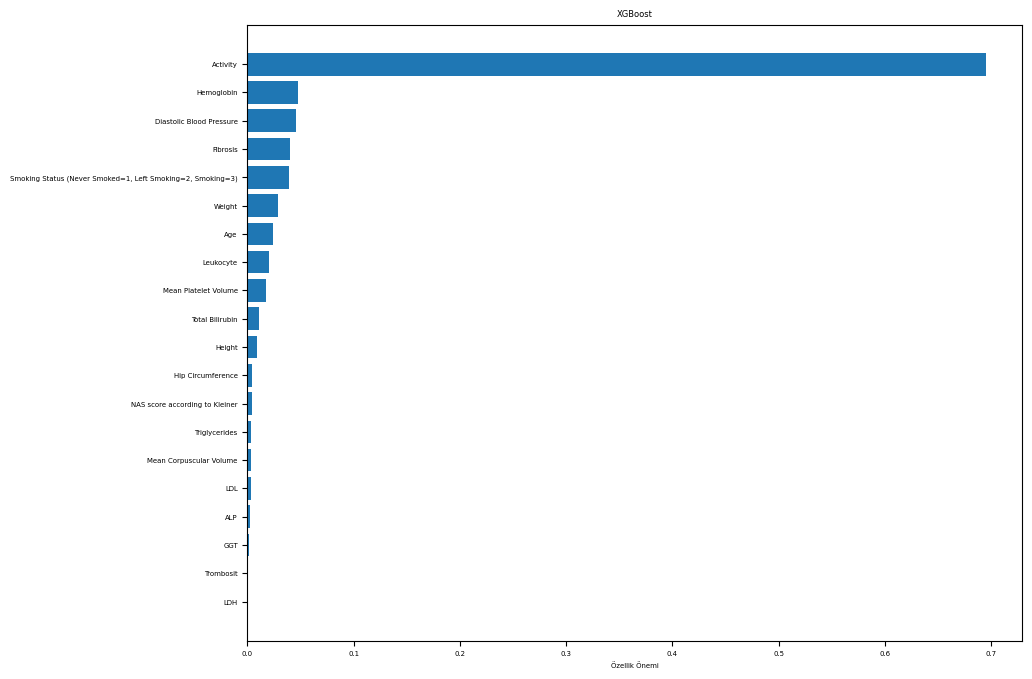

In [30]:
# XGBoost modeliyle eğitim ve değerlendirme
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# Tahminler
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Performans metrikleri
xgb_acc = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)

print("XGBoost Sonuçları:\n")
print(f"Accuracy: {xgb_acc:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}\n")

# Özellik önemleri
print("XGBoost Özellik Önemi:\n")
plot_feature_importance(xgb_model, pd.DataFrame(X_train, columns=X_train.columns), "XGBoost")

In [31]:
# Sonuçları karşılaştırmak için DataFrame oluşturma
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [rf_acc, xgb_acc],
    "Precision": [rf_precision, xgb_precision],
    "Recall": [rf_recall, xgb_recall],
    "F1 Score": [rf_f1, xgb_f1],
    "ROC-AUC": [rf_roc_auc, xgb_roc_auc]
})

print("Sonuç Karşılaştırma:\n")
print(comparison_df.sort_values(by="F1 Score", ascending=False))

Sonuç Karşılaştırma:

           Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0  Random Forest     1.000      1.000   1.000     1.000    1.000
1        XGBoost     1.000      1.000   1.000     1.000    1.000
